#### The CIR Model (definition)

A mean-reversion interest rate model that is VERY SIMILAR to the Vasicek model:

$$ dr_{t} = a(b - r_{t})dt + \sigma \sqrt{r_{t}} dW_{t} $$

where the $\sqrt{r_{t}}$ is a multiplier term to prevent negative interest rates.

In the CIR equation, the change in interest rates are a function of how far away you are from the mean  $a(b - r_{t})dt$ plus a random shock which is a function of $\sigma$.

a = the speed of mean reversion

b = long-term average interest rate (the mean to which interest rates revert)

r = interest rate

$\sigma$ = volatility scalar

W = Geometric Brownian Motion (Wiener Process)

$dW_{t}$ = a random number generated by a random normal distribution during Wiener Process

#### "Short Rate" aka "Instantaneous Rate" vs. Annualized Rate

In [1]:
#100% annualized interest on $1 loan, a single interest payment at the end of the year
PaymentAt12Months = 1 + 1*1
PaymentAt12Months

2

In [2]:
#100% annualized interest on $1 loan, two interest payments: one at 6 months, one at 12 months
PaymentAt6Months = 1 + 1*0.5
PaymentAt12Months = PaymentAt6Months + PaymentAt6Months*0.5
PaymentAt12Months

2.25

In general, if we compound every 1/N per year (i.e., N times per year at equal intervals) we get:

$$\left(1+\frac{r}{N}\right)^N$$

As: N -> inf, we get:

$$ 1+r_{AnnualizedRate}=e^{r_{ShortRate}} $$

and

$$ r_{ShortRate} = ln(1+r_{AnnualizedRate}) $$


In [3]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit as erk
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display

In [4]:
def ann_to_inst(r):
    """
    Convert annualized interest rate to short interest rate
    """
    return np.log1p(r)

def inst_to_ann(r):
    """
    Convert short interest rate to annualized interest rate
    """
    return np.expm1(r)

#### We can use the CIR model for Asset-Liability Management (ALM)

In [5]:
import math

def cir(n_years=10, n_sims=1, a=0.5, b=0.03, sigma=0.05, steps=12, r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0=b
    r_0=ann_to_inst(r_0) #important if r is big, not so important if r is small
    dt = 1/steps
    n_steps = int(n_years*steps)+1 #int() makes it so we can call 4.3 years, 2.1 years, etc...
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(n_steps, n_sims)) #m rows = n_steps, n cols = n_sims
    rates = np.empty_like(shock) #initialize
    rates[0] = r_0

    #Generate prices
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)

    for step in range(1, n_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step] #remove *np.sqrt(r_t) to get the Vasicek model
        rates[step] = abs(r_t + d_r_t) #abs() to make certain rounding errors will not produce a negative interest rate
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(n_steps))
    prices = pd.DataFrame(data=prices, index=range(n_steps))
    
    return rates, prices

In [6]:
def show_cir_prices( n_sims=10, a=0.5, b=0.03, sigma=0.05, r_0=0.03):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_sims=n_sims)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                               r_0=(0,0.15,0.01),
                               a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma = (0.0001, .1, .01),
                               n_sims=(1,100))

display(controls)

interactive(children=(IntSlider(value=10, description='n_sims', min=1), FloatSlider(value=0.5, description='a'…

In [7]:
def show_cir_rates(n_sims=10, a=0.5, b=0.03, sigma=0.05, r_0=0.03):
    cir(n_sims=n_sims, a=a, b=b, sigma=sigma, r_0=r_0)[0].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_rates,
                               a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma = (0.0001, .1, .01),
                               r_0=(0,0.15,0.01),
                               n_sims=(1,100))
display(controls)

interactive(children=(IntSlider(value=10, description='n_sims', min=1), FloatSlider(value=0.5, description='a'…

In [8]:
a_0 = 0.75                                                              #Starting balance (asset value)
rates, bond_prices = cir(r_0=0.03, b=0.03, n_years=10, n_sims=1000)       #Monte Carlo simulation for rates and prices
liabilities = bond_prices                                               #Changes in liablities are assumed to be equivalent to changes in zero-coupon bond prices
zc_10years = pd.Series(data=[1], index=[10])                            #Create a pandas Series for zero-coupon bond pricing
zc_0 = erk.pv(zc_10years, r=0.03)                                       #Price zero-coupon bond at present value
n_bonds = a_0/zc_0                                                      #The amount of zero-coupon bonds I can buy today, given a_0
av_zc = n_bonds*bond_prices                                             #Asset value compounded over time if a_0 is 100% allocated to zero-coupon bonds
av_cash = a_0*(1+rates/12).cumprod()                                    #Asset value if a_0 is 100% allocated to cash

<Axes: >

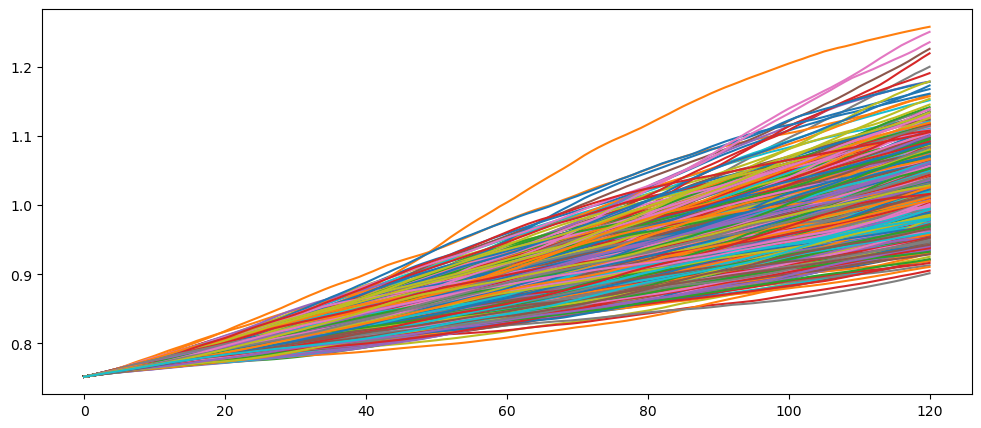

In [9]:
#Asset value over time if 100% invested in cash
av_cash.plot(legend=False, figsize=(12,5))

<Axes: >

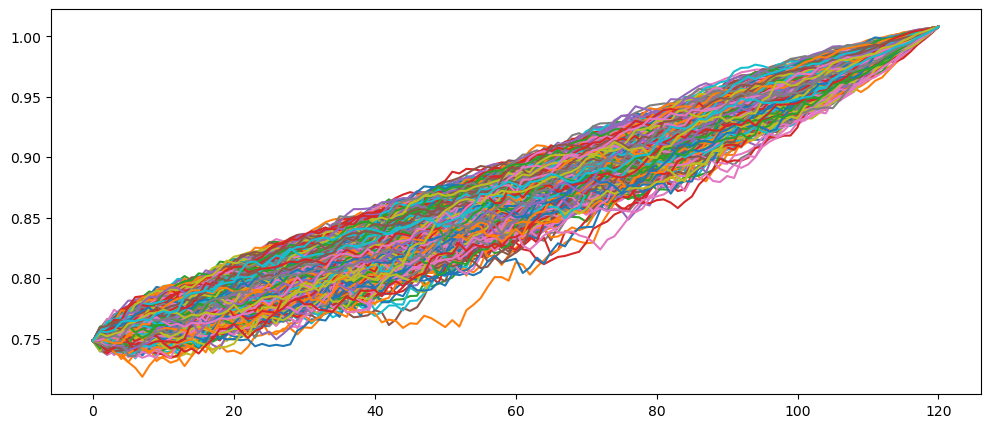

In [10]:
#Asset value over time if 100% invested in zero coupon bonds
av_zc.plot(legend=False, figsize=(12,5))

<Axes: >

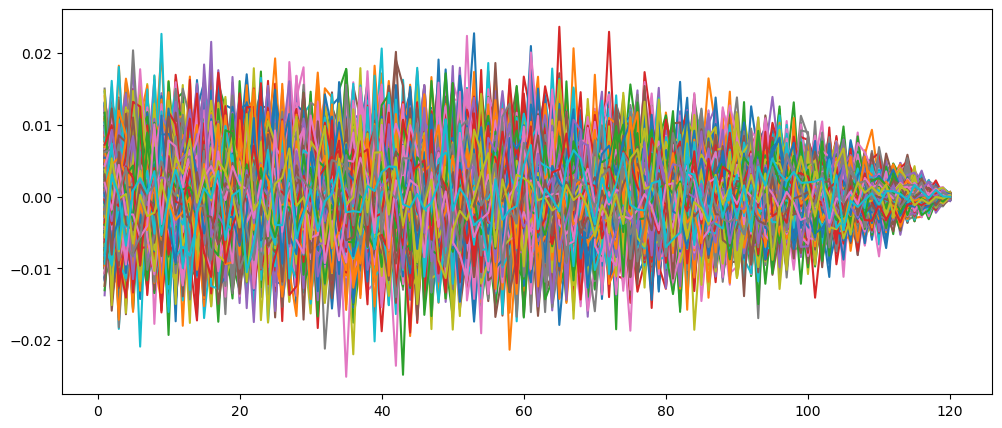

In [11]:
#Funding ratio over time if 100% invested in cash
(av_cash/liabilities).pct_change().plot(figsize=(12,5), legend=False)

<Axes: >

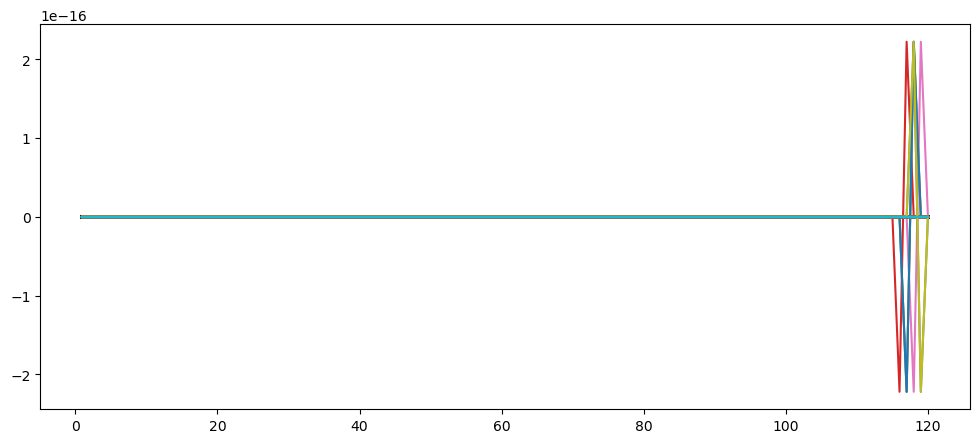

In [12]:
#Funding ratio over time if 100% invested in zero coupon bonds
(av_zc/liabilities).pct_change().plot(figsize=(12,5), legend=False)

<Axes: >

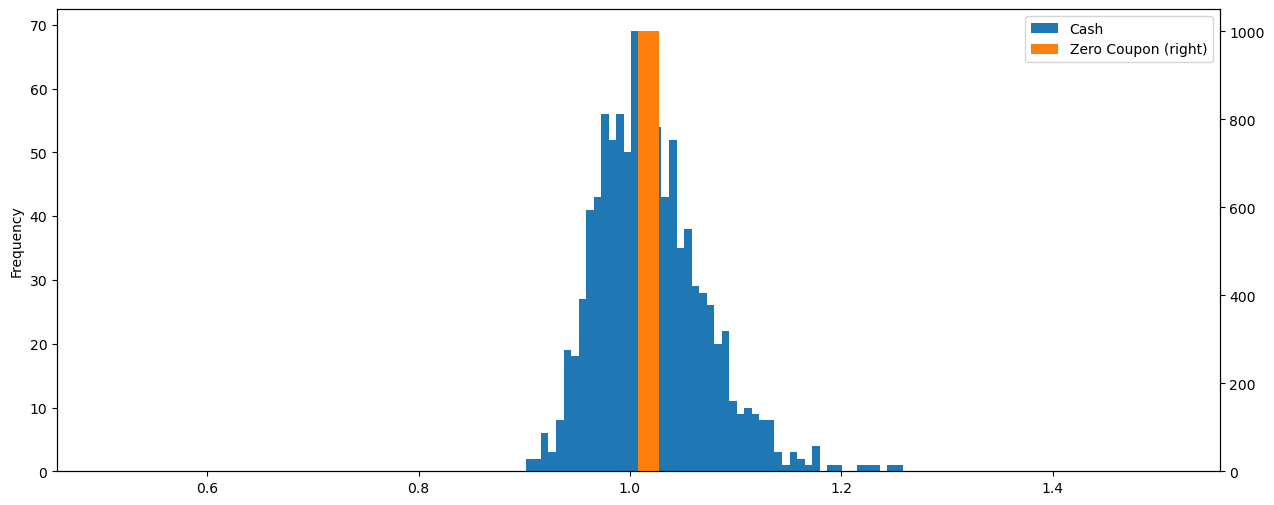

In [13]:
AvgTerminalFundingRatio_Cash = av_cash.iloc[-1]/liabilities.iloc[-1]
AvgTerminalFundingRatio_ZeroCouponBonds = av_zc.iloc[-1]/liabilities.iloc[-1]
ax = AvgTerminalFundingRatio_Cash.plot.hist(label="Cash", figsize=(15,6), bins=50, legend=True)
AvgTerminalFundingRatio_ZeroCouponBonds.plot.hist(ax=ax, label="Zero Coupon", bins=50, legend=True, secondary_y=True)